# 🏜️ Soil, Water, and Management Zone Analysis

Welcome to this advanced tutorial on **precision agriculture using satellite remote sensing**! In this notebook, you'll learn:

1. **Soil Indices** - Mapping bare soil characteristics (BSI, SI)
2. **Water/Moisture Indices** - Monitoring irrigation and soil moisture (NDMI, NDWI, MNDWI)
3. **Management Zones** - Creating field zones for variable rate applications
4. **Decision Making** - Translating data into actionable farm management

By the end, you'll understand how satellite data can guide **precision agriculture decisions** like variable rate seeding, irrigation scheduling, and targeted soil management.

---

## 📖 Background: Why Management Zones?

Agricultural fields are rarely uniform. Soil properties, moisture retention, and productivity vary across space. **Management zones** are areas within a field that share similar characteristics and can be managed uniformly.

### Traditional Approach:
- **Electrical Conductivity (EC) mapping** - Measures soil properties directly
- **Soil sampling** - Lab analysis of nutrients, texture, pH
- **Yield monitoring** - Historical productivity data

**Challenges:** Expensive, time-consuming, typically done once

### Satellite Remote Sensing Approach:
- **Free and repeatable** - Monitor fields throughout the season
- **Broad spatial coverage** - Entire field at once
- **Multi-temporal** - Track changes over time
- **Complementary** - Works alongside ground-based methods

### Research Context:

Management zone delineation has been extensively studied in precision agriculture:

- **Moral et al. (2010)** demonstrated delineation of management zones using apparent soil electrical conductivity and yield data, showing improved variable rate application strategies [[1]](#references)
- **Schepers et al. (2004)** showed that management zones based on multiple data sources (soil properties, elevation, satellite imagery) improved nitrogen management and yield [[2]](#references)
- **Recent work at SDSU Extension** emphasizes using EC measurements to create management zones that optimize input use and crop yield

**This tutorial** demonstrates how satellite-derived indices can create preliminary management zones or complement ground-based approaches.

---


## 📚 Part 1: Understanding Soil and Water Indices

### 🏜️ Soil Indices

#### Bare Soil Index (BSI)
$$
BSI = \frac{(SWIR_1 + Red) - (NIR + Blue)}{(SWIR_1 + Red) + (NIR + Blue)}
$$

- **Range:** -1 to +1
- **Higher values** → More exposed bare soil
- **Best timing:** Pre-planting or post-harvest (minimal vegetation)
- **Applications:** Soil texture mapping, erosion risk assessment, tillage monitoring

#### Soil Brightness Index (SI)
$$
SI = \sqrt{\frac{Red^2 + NIR^2}{2}}
$$

- **Range:** 0 to ∞ (typically 0-1 for normalized data)
- **Higher values** → Brighter, often lighter-textured soils (sandy)
- **Lower values** → Darker soils (high organic matter, clay, moisture)
- **Applications:** Soil texture classification, organic matter estimation

### 💧 Water/Moisture Indices

#### Normalized Difference Moisture Index (NDMI)
$$
NDMI = \frac{NIR - SWIR_1}{NIR + SWIR_1}
$$

- **Range:** -1 to +1
- **Higher values** → Higher water content in vegetation/soil
- **Applications:** Irrigation management, drought monitoring, crop water stress

#### Normalized Difference Water Index (NDWI)
$$
NDWI = \frac{Green - NIR}{Green + NIR}
$$

- **Positive values** → Water bodies
- **Applications:** Reservoir monitoring, flood mapping, irrigation pond levels

#### Modified NDWI (MNDWI)
$$
MNDWI = \frac{Green - SWIR_1}{Green + SWIR_1}
$$

- **More sensitive to water** than NDWI
- **Better performance** with turbid/sediment-laden water
- **Applications:** Wetland mapping, improved water detection

---


## 🎯 Part 2: Tutorial Objectives

We'll analyze a field through two time periods:

### Analysis 1: Pre-Planting Soil Assessment (March-April)
- Compute **soil indices** (BSI, SI) when vegetation is minimal
- Assess **soil moisture** variability (NDMI)
- Identify soil patterns for zone creation

### Analysis 2: Growing Season Monitoring (June-August)
- Track **vegetation health** (NDVI)
- Monitor **crop water stress** (NDMI)
- Compare with pre-season soil patterns

### Management Zone Creation
- Use **K-means clustering** on multiple indices
- Create **3-5 management zones**
- Generate **recommendations** for variable rate applications

---


## 🔧 Part 3: Setup and Data Access


In [1]:
# Import required libraries
from precision_ag.additional_indices import (
    AgIndexComputer,
    compute_agricultural_indices_for_aoi
)
from precision_ag.zone_analysis import (
    ManagementZoneAnalyzer,
    create_management_zones_for_field
)

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Set up nice plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Libraries imported successfully!")
print("\n📦 Available capabilities:")
print("   - Compute 10 agricultural indices (vegetation, soil, water)")
print("   - Create management zones using clustering")
print("   - Export zones for farm management software")


✅ Libraries imported successfully!

📦 Available capabilities:
   - Compute 10 agricultural indices (vegetation, soil, water)
   - Create management zones using clustering
   - Export zones for farm management software


### Define Your Area of Interest (AOI)

You can define your AOI in several ways:

1. **Bounding box** (coordinates): `[min_lon, min_lat, max_lon, max_lat]`
2. **GeoJSON file**: Path to a .geojson file with your field boundary
3. **Coordinate list**: List of (lon, lat) points

For this tutorial, we'll use a sample agricultural field in the Central Valley, California.


In [2]:
# Define a sample agricultural field
# This is a real field in California's Central Valley
# field_aoi = [-121.25, 37.95, -121.20, 38.00]

# Or use your own field:
# field_aoi = "path/to/your/field.geojson"
# field_aoi = [-lon1, lat1, -lon2, lat2]  # Your coordinates
field_aoi = [[-96.633579, 38.402637],
 [-96.637419, 38.446126],
 [-96.562589, 38.447137],
 [-96.556855, 38.40154],
 [-96.633579, 38.402637]]

print(f"📍 Field AOI defined: {field_aoi}")
print("\n💡 TIP: To use your own field:")
print("   1. Draw it on https://geojson.io")
print("   2. Save as .geojson")
print("   3. Set field_aoi = 'path/to/your_field.geojson'")


📍 Field AOI defined: [[-96.633579, 38.402637], [-96.637419, 38.446126], [-96.562589, 38.447137], [-96.556855, 38.40154], [-96.633579, 38.402637]]

💡 TIP: To use your own field:
   1. Draw it on https://geojson.io
   2. Save as .geojson
   3. Set field_aoi = 'path/to/your_field.geojson'


### What Indices Can We Compute?

Let's see what indices are available for our satellite collection (Sentinel-2):


In [3]:
# Create an index computer
computer = AgIndexComputer(collection="sentinel-2-l2a")

# Show all available indices with details
computer.print_index_info()



AGRICULTURAL INDICES - Collection: sentinel-2-l2a


🌱 VEGETATION INDICES
----------------------------------------------------------------------

NDVI - Normalized Difference Vegetation Index
Status: ✅ Available
Formula: (NIR - Red) / (NIR + Red)
Range: (-1, 1)
Best for: General purpose vegetation monitoring

EVI - Enhanced Vegetation Index
Status: ✅ Available
Formula: 2.5 * (NIR - Red) / (NIR + 6*Red - 7.5*Blue + 1)
Range: (-1, 1)
Best for: Dense vegetation, reduced atmospheric effects

SAVI - Soil Adjusted Vegetation Index
Status: ✅ Available
Formula: ((NIR - Red) / (NIR + Red + L)) * (1 + L), L=0.5
Range: (-1, 1)
Best for: Sparse vegetation, early season crops, exposed soil

NDRE - Normalized Difference Red Edge
Status: ✅ Available
Formula: (NIR - RedEdge) / (NIR + RedEdge)
Range: (-1, 1)
Best for: Precision nitrogen management, disease detection
Note: Sentinel-2 only (requires Red Edge bands)

GNDVI - Green Normalized Difference Vegetation Index
Status: ✅ Available
Formula: (NIR - 

---

## 🌱 Part 4: Pre-Season Soil Assessment

### Why Analyze Bare Soil?

**Pre-planting** (March-April in many regions) is the ideal time to assess soil characteristics:
- Minimal vegetation interference
- Soil spectral signature is clearly visible
- Guides planting decisions and input applications

### What We'll Compute:
- **BSI** - Soil exposure and texture patterns
- **SI** - Soil brightness (texture, organic matter)
- **NDMI** - Soil moisture variability


🔍 Searching for satellite imagery...
   Time period: March 15 - April 15, 2024
   Indices: BSI, SI, NDMI

⏳ This may take 1-2 minutes...


Agricultural Index Computer - sentinel-2-l2a
Requested indices: bsi, si, ndmi
Available indices: ndvi, evi, savi, ndre, gndvi, bsi, si, ndmi, ndwi, mndwi

Loading AOI...

Searching for sentinel-2-l2a data from 2024-03-15 to 2024-04-15...
Found 7 scenes matching criteria

Processing scene 1/7

Processing scene: S2A_MSIL2A_20240413T170851_R112_T14SQH_20240414T012029
Date: 2024-04-13 17:08:51.024000+00:00
Computing indices: bsi, si, ndmi
Loading bands: blue, nir, red, swir1
    Resampling swir1 from (256, 360) to (511, 718)
  Computing BSI...
    Saved to: tutorial_output/soil_analysis/bsi_S2A_MSIL2A_20240413T170851_R112_T14SQH_20240414T012029.tif
  Computing SI...
    Saved to: tutorial_output/soil_analysis/si_S2A_MSIL2A_20240413T170851_R112_T14SQH_20240414T012029.tif
  Computing NDMI...
    Saved to: tutorial_output/soil_analysis/ndmi_S2A_MSIL2A_2024

/Users/chris/projects/precision-ag/precision-ag/additional_indices.py:546: RuntimeWarning: invalid value encountered in divide
  numerator / denominator,
/Users/chris/projects/precision-ag/precision-ag/additional_indices.py:564: RuntimeWarning: invalid value encountered in divide
  (nir - swir1) / denominator,


Figure saved to: tutorial_output/soil_analysis/comparison_S2A_MSIL2A_20240413T170851_R112_T14SQH_20240414T012029.png


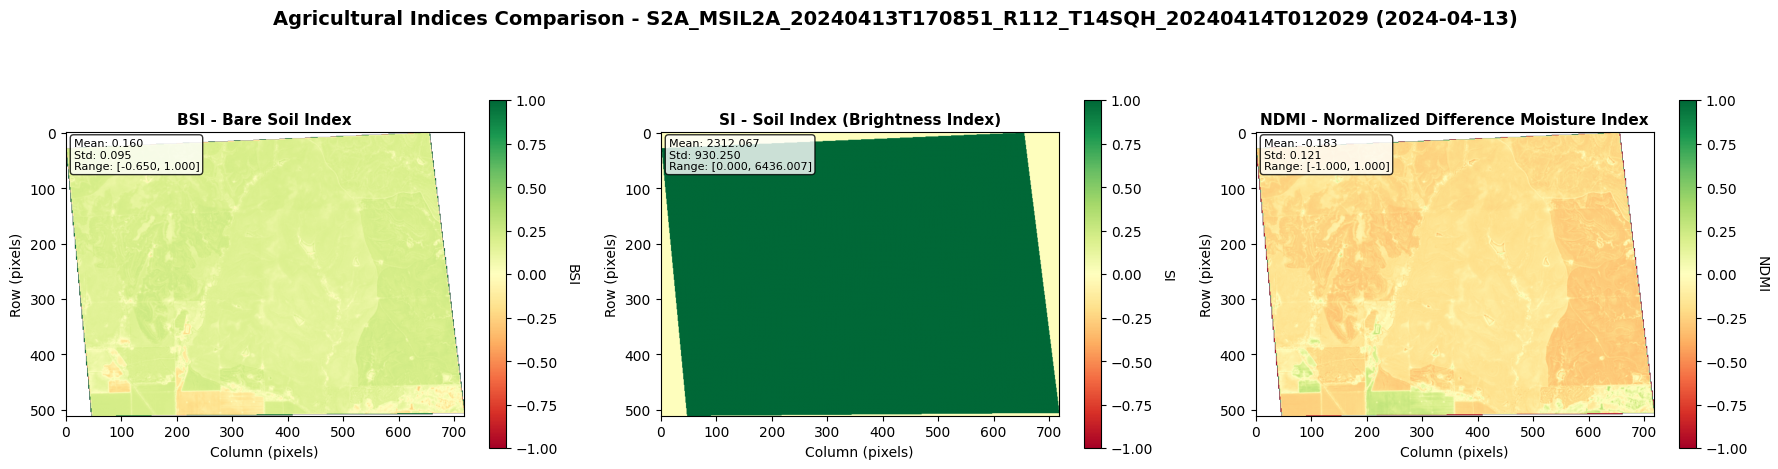


📊 Statistics Summary:

  BSI:
    Mean: 0.160
    Range: [-0.650, 1.000]
    Valid pixels: 329,019

  SI:
    Mean: 2312.067
    Range: [0.000, 6436.007]
    Valid pixels: 366,898

  NDMI:
    Mean: -0.183
    Range: [-1.000, 1.000]
    Valid pixels: 329,019

Processing scene 2/7

Processing scene: S2A_MSIL2A_20240413T170851_R112_T14SPH_20240414T012027
Date: 2024-04-13 17:08:51.024000+00:00
Computing indices: bsi, si, ndmi
Loading bands: blue, nir, red, swir1
    Resampling swir1 from (256, 182) to (511, 363)
  Computing BSI...
    Saved to: tutorial_output/soil_analysis/bsi_S2A_MSIL2A_20240413T170851_R112_T14SPH_20240414T012027.tif
  Computing SI...
    Saved to: tutorial_output/soil_analysis/si_S2A_MSIL2A_20240413T170851_R112_T14SPH_20240414T012027.tif
  Computing NDMI...
    Saved to: tutorial_output/soil_analysis/ndmi_S2A_MSIL2A_20240413T170851_R112_T14SPH_20240414T012027.tif
✅ All indices computed successfully!



/Users/chris/projects/precision-ag/precision-ag/additional_indices.py:546: RuntimeWarning: invalid value encountered in divide
  numerator / denominator,
/Users/chris/projects/precision-ag/precision-ag/additional_indices.py:564: RuntimeWarning: invalid value encountered in divide
  (nir - swir1) / denominator,


Figure saved to: tutorial_output/soil_analysis/comparison_S2A_MSIL2A_20240413T170851_R112_T14SPH_20240414T012027.png


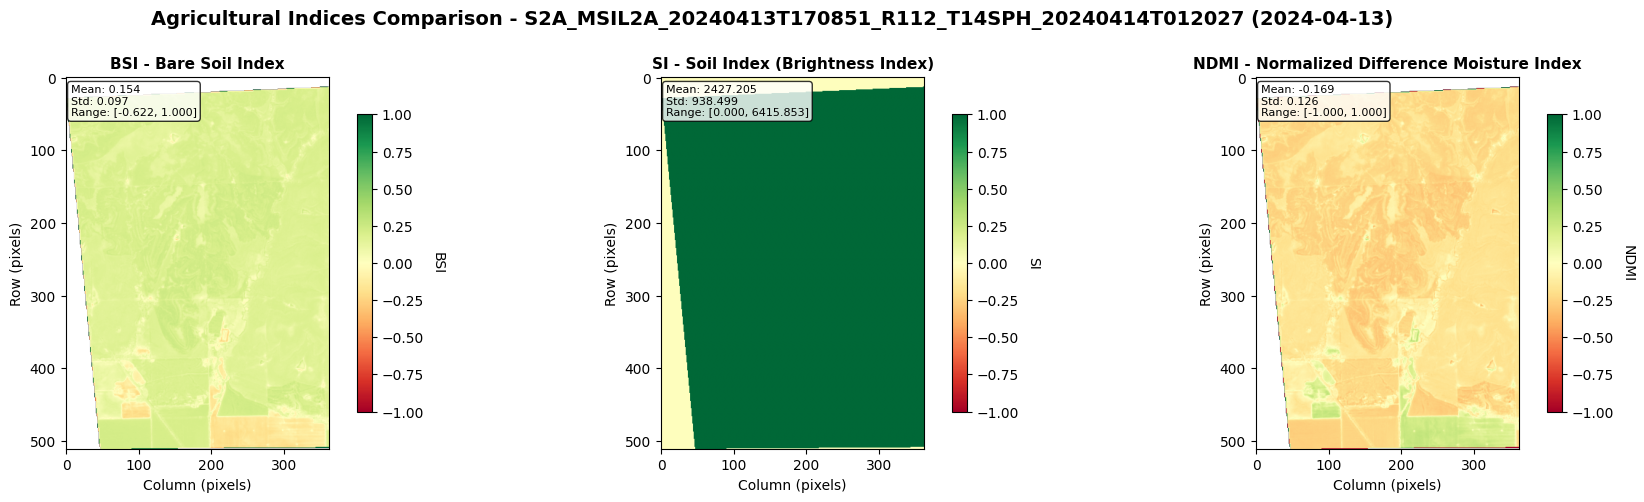


📊 Statistics Summary:

  BSI:
    Mean: 0.154
    Range: [-0.622, 1.000]
    Valid pixels: 166,316

  SI:
    Mean: 2427.205
    Range: [0.000, 6415.853]
    Valid pixels: 185,493

  NDMI:
    Mean: -0.169
    Range: [-1.000, 1.000]
    Valid pixels: 166,316

Processing scene 3/7

Processing scene: S2B_MSIL2A_20240408T170849_R112_T14SQH_20240411T102730
Date: 2024-04-08 17:08:49.024000+00:00
Computing indices: bsi, si, ndmi
Loading bands: blue, nir, red, swir1
    Resampling swir1 from (256, 360) to (511, 718)
  Computing BSI...
    Saved to: tutorial_output/soil_analysis/bsi_S2B_MSIL2A_20240408T170849_R112_T14SQH_20240411T102730.tif
  Computing SI...
    Saved to: tutorial_output/soil_analysis/si_S2B_MSIL2A_20240408T170849_R112_T14SQH_20240411T102730.tif
  Computing NDMI...
    Saved to: tutorial_output/soil_analysis/ndmi_S2B_MSIL2A_20240408T170849_R112_T14SQH_20240411T102730.tif
✅ All indices computed successfully!



/Users/chris/projects/precision-ag/precision-ag/additional_indices.py:546: RuntimeWarning: invalid value encountered in divide
  numerator / denominator,
/Users/chris/projects/precision-ag/precision-ag/additional_indices.py:564: RuntimeWarning: invalid value encountered in divide
  (nir - swir1) / denominator,


Figure saved to: tutorial_output/soil_analysis/comparison_S2B_MSIL2A_20240408T170849_R112_T14SQH_20240411T102730.png


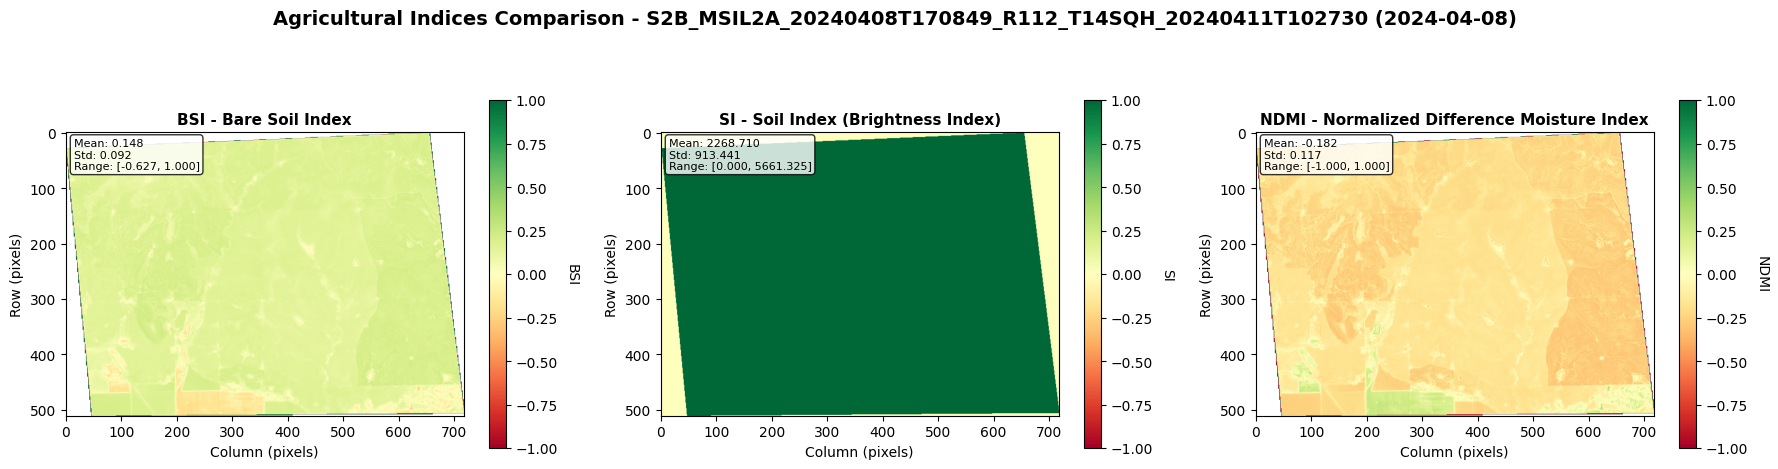


📊 Statistics Summary:

  BSI:
    Mean: 0.148
    Range: [-0.627, 1.000]
    Valid pixels: 329,019

  SI:
    Mean: 2268.710
    Range: [0.000, 5661.325]
    Valid pixels: 366,898

  NDMI:
    Mean: -0.182
    Range: [-1.000, 1.000]
    Valid pixels: 329,019

Processing scene 4/7

Processing scene: S2B_MSIL2A_20240408T170849_R112_T14SPH_20240411T102529
Date: 2024-04-08 17:08:49.024000+00:00
Computing indices: bsi, si, ndmi
Loading bands: blue, nir, red, swir1
    Resampling swir1 from (256, 182) to (511, 363)
  Computing BSI...
    Saved to: tutorial_output/soil_analysis/bsi_S2B_MSIL2A_20240408T170849_R112_T14SPH_20240411T102529.tif
  Computing SI...
    Saved to: tutorial_output/soil_analysis/si_S2B_MSIL2A_20240408T170849_R112_T14SPH_20240411T102529.tif
  Computing NDMI...
    Saved to: tutorial_output/soil_analysis/ndmi_S2B_MSIL2A_20240408T170849_R112_T14SPH_20240411T102529.tif
✅ All indices computed successfully!



/Users/chris/projects/precision-ag/precision-ag/additional_indices.py:546: RuntimeWarning: invalid value encountered in divide
  numerator / denominator,
/Users/chris/projects/precision-ag/precision-ag/additional_indices.py:564: RuntimeWarning: invalid value encountered in divide
  (nir - swir1) / denominator,


Figure saved to: tutorial_output/soil_analysis/comparison_S2B_MSIL2A_20240408T170849_R112_T14SPH_20240411T102529.png


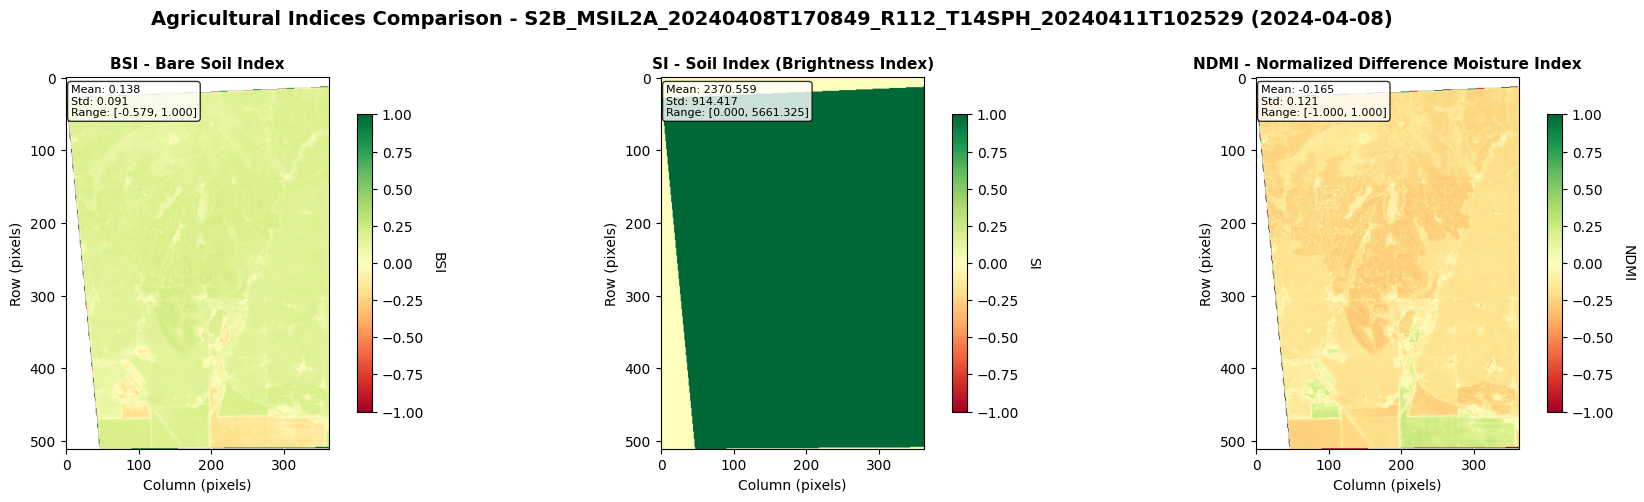


📊 Statistics Summary:

  BSI:
    Mean: 0.138
    Range: [-0.579, 1.000]
    Valid pixels: 166,316

  SI:
    Mean: 2370.559
    Range: [0.000, 5661.325]
    Valid pixels: 185,493

  NDMI:
    Mean: -0.165
    Range: [-1.000, 1.000]
    Valid pixels: 166,316

Processing scene 5/7

Processing scene: S2A_MSIL2A_20240403T170851_R112_T14SQH_20240404T022549
Date: 2024-04-03 17:08:51.024000+00:00
Computing indices: bsi, si, ndmi
Loading bands: blue, nir, red, swir1
    Resampling swir1 from (256, 360) to (511, 718)
  Computing BSI...
    Saved to: tutorial_output/soil_analysis/bsi_S2A_MSIL2A_20240403T170851_R112_T14SQH_20240404T022549.tif
  Computing SI...
    Saved to: tutorial_output/soil_analysis/si_S2A_MSIL2A_20240403T170851_R112_T14SQH_20240404T022549.tif
  Computing NDMI...
    Saved to: tutorial_output/soil_analysis/ndmi_S2A_MSIL2A_20240403T170851_R112_T14SQH_20240404T022549.tif
✅ All indices computed successfully!



/Users/chris/projects/precision-ag/precision-ag/additional_indices.py:546: RuntimeWarning: invalid value encountered in divide
  numerator / denominator,
/Users/chris/projects/precision-ag/precision-ag/additional_indices.py:564: RuntimeWarning: invalid value encountered in divide
  (nir - swir1) / denominator,


Figure saved to: tutorial_output/soil_analysis/comparison_S2A_MSIL2A_20240403T170851_R112_T14SQH_20240404T022549.png


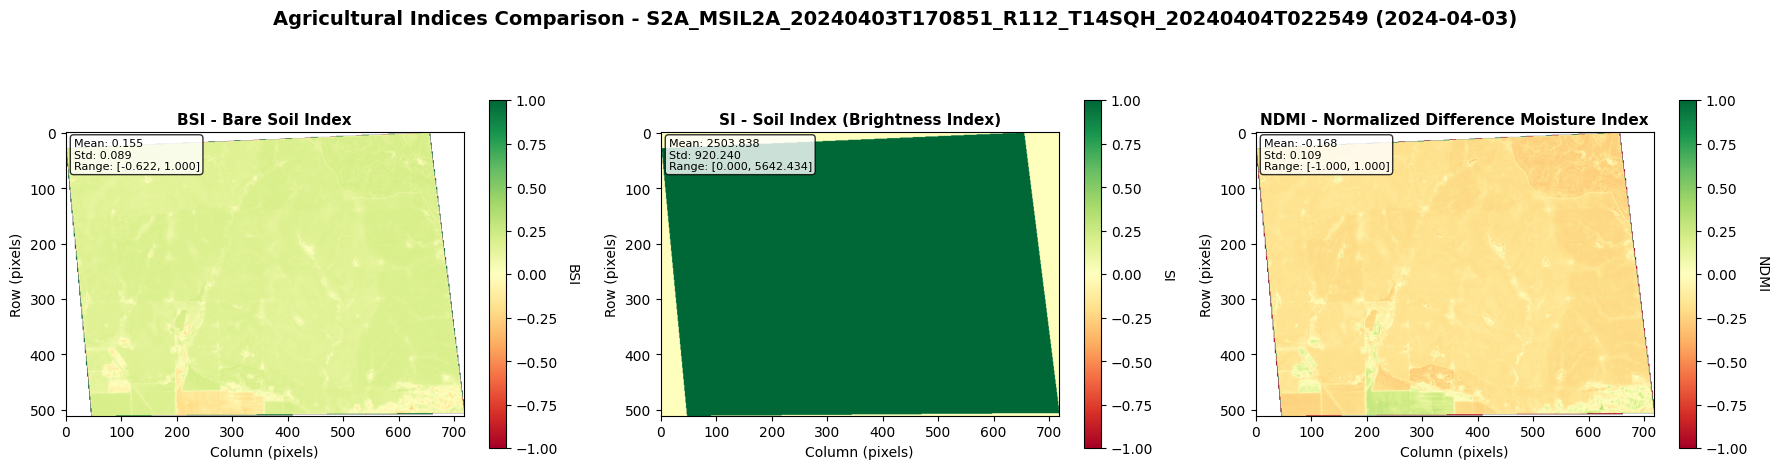


📊 Statistics Summary:

  BSI:
    Mean: 0.155
    Range: [-0.622, 1.000]
    Valid pixels: 329,019

  SI:
    Mean: 2503.838
    Range: [0.000, 5642.434]
    Valid pixels: 366,898

  NDMI:
    Mean: -0.168
    Range: [-1.000, 1.000]
    Valid pixels: 329,019

Processing scene 6/7

Processing scene: S2A_MSIL2A_20240403T170851_R112_T14SPH_20240404T021705
Date: 2024-04-03 17:08:51.024000+00:00
Computing indices: bsi, si, ndmi
Loading bands: blue, nir, red, swir1
    Resampling swir1 from (256, 182) to (511, 363)
  Computing BSI...
    Saved to: tutorial_output/soil_analysis/bsi_S2A_MSIL2A_20240403T170851_R112_T14SPH_20240404T021705.tif
  Computing SI...
    Saved to: tutorial_output/soil_analysis/si_S2A_MSIL2A_20240403T170851_R112_T14SPH_20240404T021705.tif
  Computing NDMI...
    Saved to: tutorial_output/soil_analysis/ndmi_S2A_MSIL2A_20240403T170851_R112_T14SPH_20240404T021705.tif
✅ All indices computed successfully!



/Users/chris/projects/precision-ag/precision-ag/additional_indices.py:546: RuntimeWarning: invalid value encountered in divide
  numerator / denominator,
/Users/chris/projects/precision-ag/precision-ag/additional_indices.py:564: RuntimeWarning: invalid value encountered in divide
  (nir - swir1) / denominator,


Figure saved to: tutorial_output/soil_analysis/comparison_S2A_MSIL2A_20240403T170851_R112_T14SPH_20240404T021705.png


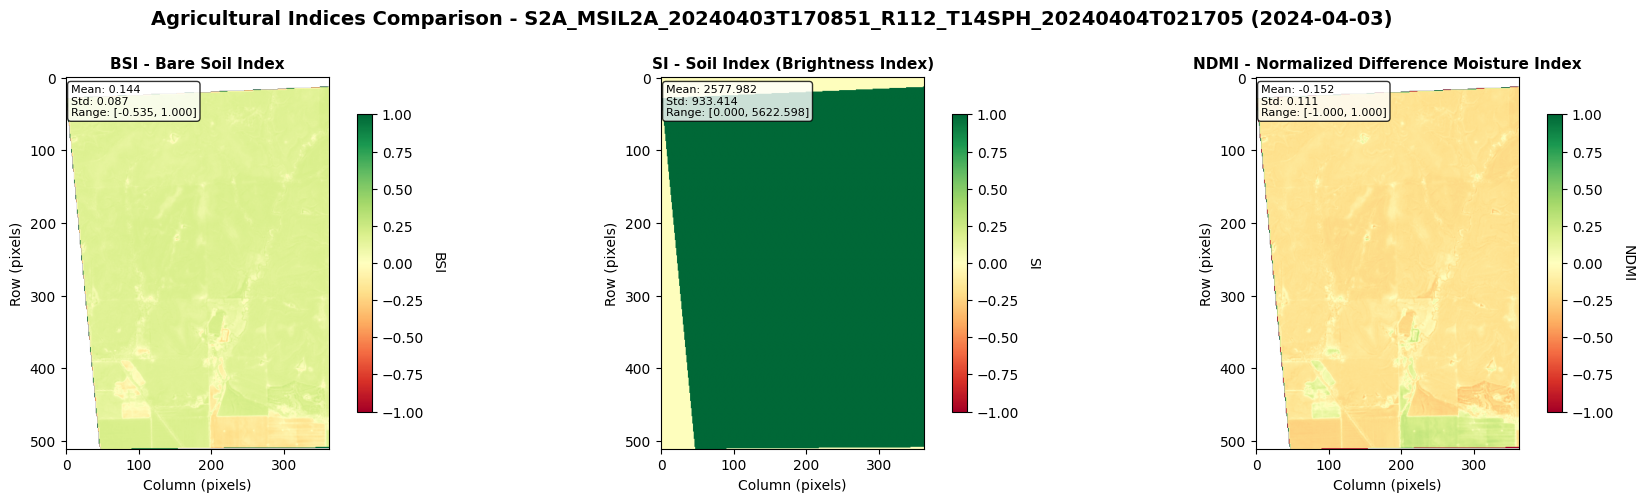


📊 Statistics Summary:

  BSI:
    Mean: 0.144
    Range: [-0.535, 1.000]
    Valid pixels: 166,316

  SI:
    Mean: 2577.982
    Range: [0.000, 5622.598]
    Valid pixels: 185,493

  NDMI:
    Mean: -0.152
    Range: [-1.000, 1.000]
    Valid pixels: 166,316

Processing scene 7/7

Processing scene: S2B_MSIL2A_20240319T170919_R112_T14SQH_20240319T223454
Date: 2024-03-19 17:09:19.024000+00:00
Computing indices: bsi, si, ndmi
Loading bands: blue, nir, red, swir1
    Resampling swir1 from (256, 360) to (511, 718)
  Computing BSI...
    Saved to: tutorial_output/soil_analysis/bsi_S2B_MSIL2A_20240319T170919_R112_T14SQH_20240319T223454.tif
  Computing SI...
    Saved to: tutorial_output/soil_analysis/si_S2B_MSIL2A_20240319T170919_R112_T14SQH_20240319T223454.tif
  Computing NDMI...
    Saved to: tutorial_output/soil_analysis/ndmi_S2B_MSIL2A_20240319T170919_R112_T14SQH_20240319T223454.tif
✅ All indices computed successfully!



/Users/chris/projects/precision-ag/precision-ag/additional_indices.py:546: RuntimeWarning: invalid value encountered in divide
  numerator / denominator,
/Users/chris/projects/precision-ag/precision-ag/additional_indices.py:564: RuntimeWarning: invalid value encountered in divide
  (nir - swir1) / denominator,


Figure saved to: tutorial_output/soil_analysis/comparison_S2B_MSIL2A_20240319T170919_R112_T14SQH_20240319T223454.png


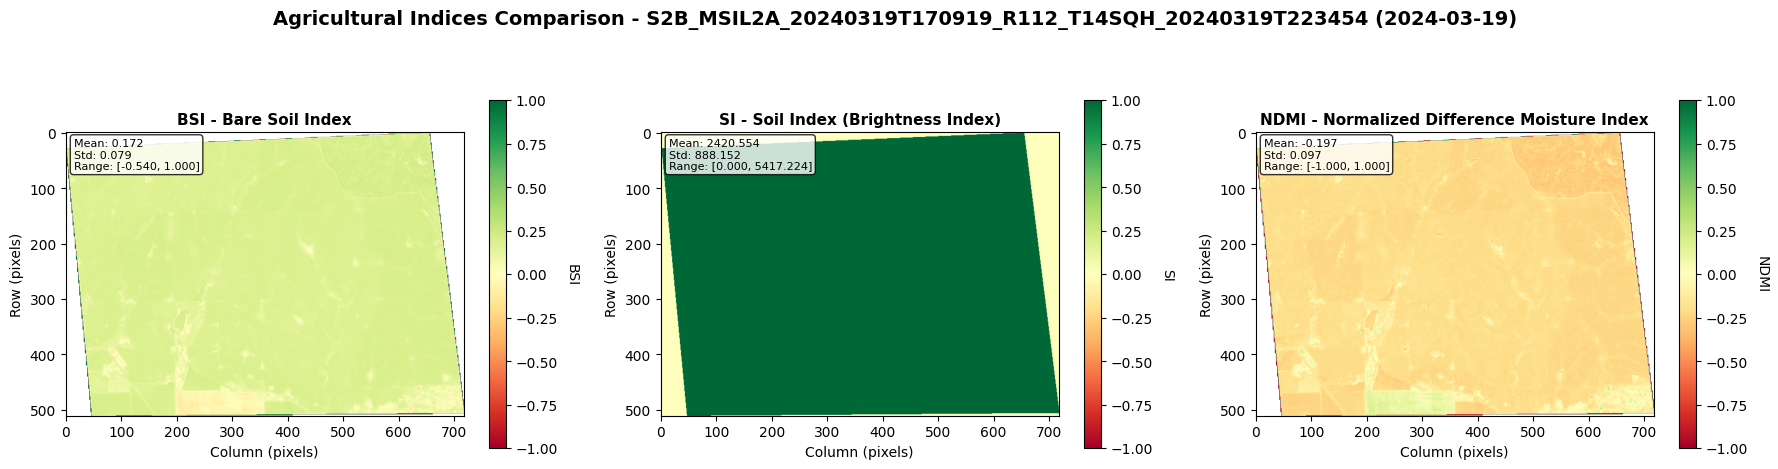


📊 Statistics Summary:

  BSI:
    Mean: 0.172
    Range: [-0.540, 1.000]
    Valid pixels: 329,019

  SI:
    Mean: 2420.554
    Range: [0.000, 5417.224]
    Valid pixels: 366,898

  NDMI:
    Mean: -0.197
    Range: [-1.000, 1.000]
    Valid pixels: 329,019

PROCESSING COMPLETE
✅ Successfully processed: 7 scenes
📁 Outputs saved to: /Users/chris/projects/precision-ag/notebooks/tutorial_output/soil_analysis


✅ Found and processed 7 scene(s)!


In [4]:
# Compute soil indices for pre-planting period
print("🔍 Searching for satellite imagery...")
print("   Time period: March 15 - April 15, 2024")
print("   Indices: BSI, SI, NDMI")
print("\n⏳ This may take 1-2 minutes...\n")

soil_results = compute_agricultural_indices_for_aoi(
    aoi_input=field_aoi,
    start_date="2024-03-15",
    end_date="2024-04-15",
    indices=['bsi', 'si', 'ndmi'],
    output_dir="tutorial_output/soil_analysis",
    max_cloud_cover=20,
    visualize=True
)

print(f"\n✅ Found and processed {len(soil_results)} scene(s)!")


### 📊 Interpreting Soil Index Results

Look at the visualization above and consider:

#### Bare Soil Index (BSI):
- **Red/orange areas**: High bare soil exposure
- **Green areas**: Some vegetation cover or darker soils
- **Patterns**: Do you see zones of consistent soil exposure?

#### Soil Brightness Index (SI):
- **Bright areas (yellow/red)**: Lighter soils (sandy, low organic matter)
- **Dark areas (green/blue)**: Heavier soils (clay, high organic matter, or moist)
- **Patterns**: Spatial texture differences across the field

#### Moisture Index (NDMI):
- **High values (green)**: Better soil moisture retention
- **Low values (red)**: Drier areas, potentially sandy or well-drained soils
- **Patterns**: Which areas naturally retain more moisture?

### 💡 Management Implications:

Areas with:
- **High BSI + High SI + Low NDMI** → Sandy, well-drained soils (may need more irrigation)
- **Low BSI + Low SI + High NDMI** → Heavier soils, better moisture retention
- Consistent patterns suggest **distinct management zones**!


In [5]:
# Extract the index data from the first (best) scene
if soil_results:
    scene_id, soil_indices = soil_results[0]
    
    print(f"📊 Analyzing scene: {scene_id}\n")
    
    # Print statistics for each index
    for idx_name, (idx_array, metadata) in soil_indices.items():
        valid_data = idx_array[~np.isnan(idx_array)]
        
        print(f"{idx_name.upper()}:")
        print(f"  Mean:   {valid_data.mean():.3f}")
        print(f"  Median: {np.median(valid_data):.3f}")
        print(f"  Std:    {valid_data.std():.3f}")
        print(f"  Range:  [{valid_data.min():.3f}, {valid_data.max():.3f}]")
        print()
else:
    print("⚠️  No cloud-free imagery found for this period.")
    print("   Try adjusting the date range or max_cloud_cover parameter.")


📊 Analyzing scene: S2A_MSIL2A_20240413T170851_R112_T14SQH_20240414T012029

BSI:
  Mean:   0.160
  Median: 0.171
  Std:    0.095
  Range:  [-0.650, 1.000]

SI:
  Mean:   2312.067
  Median: 2589.529
  Std:    930.250
  Range:  [0.000, 6436.007]

NDMI:
  Mean:   -0.183
  Median: -0.190
  Std:    0.121
  Range:  [-1.000, 1.000]



---

## 🗺️ Part 5: Creating Management Zones

### What Are Management Zones?

Management zones are **sub-field regions** with similar productivity potential and management needs. They enable:

- ✅ **Variable rate seeding** - Adjust seed rates by zone
- ✅ **Variable rate fertilization** - Apply more nutrients where needed
- ✅ **Precision irrigation** - Target water to specific areas
- ✅ **Targeted soil sampling** - Sample strategically by zone
- ✅ **Zone-specific management** - Different practices per zone

### How We Create Zones:

1. **Multi-index input** - Use BSI, SI, NDMI (or other relevant indices)
2. **K-means clustering** - Group similar pixels together
3. **Zone validation** - Check if zones make sense agronomically
4. **Export for use** - Create GeoTIFF for farm management software

### Research Foundation:

This approach follows established precision agriculture practices:
- **Clustering analysis** is widely used for zone delineation (Moral et al., 2010)
- **Multiple data layers** improve zone quality (Schepers et al., 2004)
- **Satellite data** provides cost-effective preliminary zones
- Can be **validated with ground data** (EC, soil samples, yield) when available


🗺️  Creating management zones...
   Method: K-means clustering
   Number of zones: 3
   Indices used: BSI, SI, NDMI


CREATING 3 MANAGEMENT ZONES

Preparing data for 3 indices...
  BSI: 329,019 valid pixels
  SI: 366,898 valid pixels
  NDMI: 329,019 valid pixels

Valid pixels (all indices): 329,019 / 366,898

Standardizing features...
Performing K-means clustering with 3 clusters...

✅ Zone creation complete!

ZONE SUMMARY

Zone 0:
  Pixels: 124,369 (37.8%)
  Characteristics:
    BSI: 0.210 (±0.097)
    SI: 2042.149 (±355.483)
    NDMI: -0.262 (±0.094)

Zone 1:
  Pixels: 188,291 (57.2%)
  Characteristics:
    BSI: 0.150 (±0.034)
    SI: 2855.793 (±224.050)
    NDMI: -0.161 (±0.045)

Zone 2:
  Pixels: 16,359 (5.0%)
  Characteristics:
    BSI: -0.104 (±0.083)
    SI: 3459.426 (±467.948)
    NDMI: 0.176 (±0.148)


Figure saved to: tutorial_output/management_zones/management_zones.png


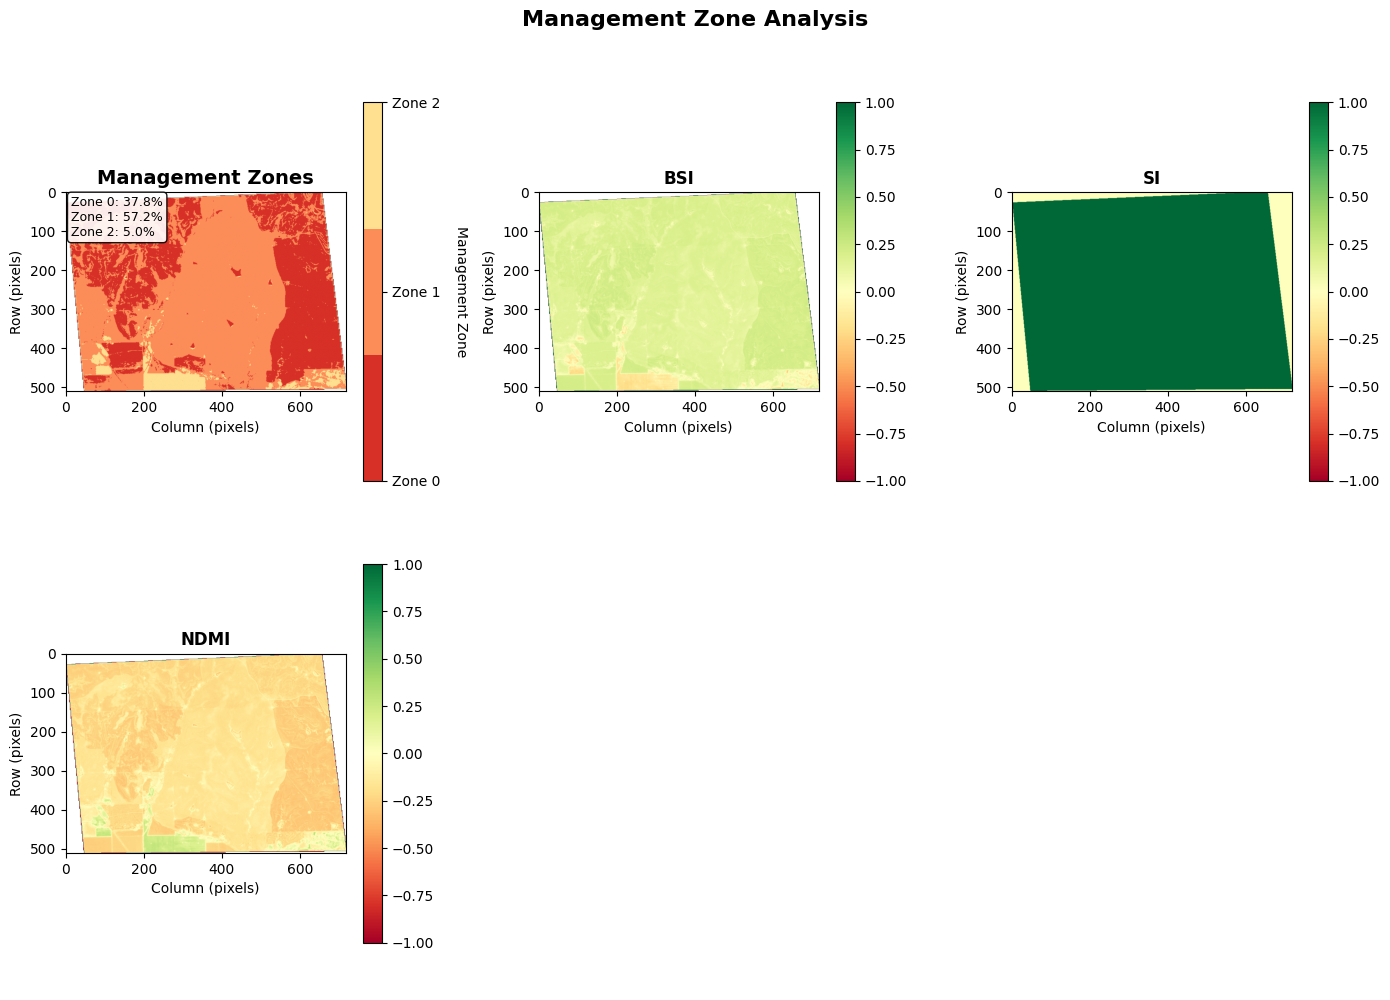


✅ Zones exported to: tutorial_output/management_zones/management_zones.tif

MANAGEMENT RECOMMENDATIONS

Zone 0 (37.8% of field):
  💧 Low moisture - increase irrigation or monitor closely

Zone 1 (57.2% of field):
  💧 Low moisture - increase irrigation or monitor closely

Zone 2 (5.0% of field):
  💧 Low moisture - increase irrigation or monitor closely


Zone analysis complete! Outputs saved to: /Users/chris/projects/precision-ag/notebooks/tutorial_output/management_zones


✅ Management zones created and saved!
   📁 Output directory: tutorial_output/management_zones/
   📊 Visualization: management_zones.png
   🗺️  GeoTIFF file: management_zones.tif

💡 The GeoTIFF can be imported into:
   - QGIS or ArcGIS
   - Farm management software (Ag Leader, John Deere Operations Center, etc.)
   - Precision agriculture equipment for variable rate applications


In [6]:
# Create management zones from soil analysis data
if soil_results:
    print("🗺️  Creating management zones...")
    print("   Method: K-means clustering")
    print("   Number of zones: 3")
    print("   Indices used: BSI, SI, NDMI\n")
    
    zones = create_management_zones_for_field(
        indices_results=soil_indices,  # Use soil data from pre-season
        n_zones=3,  # Typical: 3-5 zones
        output_dir="tutorial_output/management_zones",
        visualize=True,
        export=True  # Creates GeoTIFF file
    )
    
    print("\n✅ Management zones created and saved!")
    print("   📁 Output directory: tutorial_output/management_zones/")
    print("   📊 Visualization: management_zones.png")
    print("   🗺️  GeoTIFF file: management_zones.tif")
    print("\n💡 The GeoTIFF can be imported into:")
    print("   - QGIS or ArcGIS")
    print("   - Farm management software (Ag Leader, John Deere Operations Center, etc.)")
    print("   - Precision agriculture equipment for variable rate applications")
else:
    print("⚠️  No soil data available. Run the soil analysis section first.")


### 📊 Understanding Your Zones

The zone analysis automatically provides:
- **Zone statistics** for each index
- **Area coverage** (% of field in each zone)
- **Management recommendations** based on zone characteristics

### Typical Zone Interpretation:

#### Zone 0 (Often: Low Productivity)
- **Characteristics**: High BSI, high SI, low NDMI
- **Soil type**: Sandy, well-drained
- **Management**: 
  - Increase irrigation frequency
  - Consider split fertilizer applications
  - May benefit from lower seeding rates

#### Zone 1 (Often: Medium Productivity)
- **Characteristics**: Moderate values across indices
- **Soil type**: Loam, balanced properties
- **Management**:
  - Standard management practices
  - Baseline for comparisons

#### Zone 2 (Often: High Productivity)
- **Characteristics**: Low BSI, low SI, high NDMI
- **Soil type**: Clay loam, good moisture retention
- **Management**:
  - Can support higher seeding rates
  - May need less frequent irrigation
  - Target for maximum yield optimization


In [7]:
# Analyze zone characteristics in detail
if 'zones' in locals() and zones is not None:
    print("📈 DETAILED ZONE ANALYSIS\n")
    print("=" * 70)
    
    stats = zones['statistics']
    index_names = zones['index_names']
    
    for zone_key in sorted(stats.keys()):
        zone_id = int(zone_key.split('_')[1])
        zone_data = stats[zone_key]
        
        print(f"\n🗺️  ZONE {zone_id}")
        print("-" * 70)
        print(f"Area: {zone_data['area_percentage']:.1f}% of field ({zone_data['pixel_count']:,} pixels)")
        
        print("\nIndex Values (mean ± std):")
        for idx_name in index_names:
            if idx_name in zone_data['indices']:
                idx_stats = zone_data['indices'][idx_name]
                print(f"  {idx_name.upper():8s}: {idx_stats['mean']:6.3f} ± {idx_stats['std']:.3f}")
        
        # Interpretation
        print("\n💡 Interpretation:")
        if 'bsi' in zone_data['indices']:
            bsi = zone_data['indices']['bsi']['mean']
            if bsi > 0.2:
                print("  • High bare soil exposure - lighter textured soils likely")
            elif bsi < 0.0:
                print("  • Low bare soil exposure - vegetation cover or darker soils")
        
        if 'ndmi' in zone_data['indices']:
            ndmi = zone_data['indices']['ndmi']['mean']
            if ndmi > 0.3:
                print("  • Good moisture retention - heavier soils or well-watered")
            elif ndmi < 0.1:
                print("  • Lower moisture retention - may need more frequent irrigation")
        
        if 'si' in zone_data['indices']:
            si = zone_data['indices']['si']['mean']
            all_si = [stats[k]['indices']['si']['mean'] for k in stats.keys() if 'si' in stats[k]['indices']]
            if si > np.mean(all_si):
                print("  • Brighter soils - sandy texture or lower organic matter")
            else:
                print("  • Darker soils - higher clay/organic matter content")
    
    print("\n" + "=" * 70)


📈 DETAILED ZONE ANALYSIS


🗺️  ZONE 0
----------------------------------------------------------------------
Area: 37.8% of field (124,369 pixels)

Index Values (mean ± std):
  BSI     :  0.210 ± 0.097
  SI      : 2042.149 ± 355.483
  NDMI    : -0.262 ± 0.094

💡 Interpretation:
  • High bare soil exposure - lighter textured soils likely
  • Lower moisture retention - may need more frequent irrigation
  • Darker soils - higher clay/organic matter content

🗺️  ZONE 1
----------------------------------------------------------------------
Area: 57.2% of field (188,291 pixels)

Index Values (mean ± std):
  BSI     :  0.150 ± 0.034
  SI      : 2855.793 ± 224.050
  NDMI    : -0.161 ± 0.045

💡 Interpretation:
  • Lower moisture retention - may need more frequent irrigation
  • Brighter soils - sandy texture or lower organic matter

🗺️  ZONE 2
----------------------------------------------------------------------
Area: 5.0% of field (16,359 pixels)

Index Values (mean ± std):
  BSI     : -0.104

---

## 🎓 Part 6: Summary and Next Steps

### What You've Learned:

1. ✅ **Soil indices** (BSI, SI) reveal soil texture and brightness patterns
2. ✅ **Moisture indices** (NDMI, NDWI) track water availability
3. ✅ **Management zones** can be created from satellite data using clustering
4. ✅ **Variable rate prescriptions** optimize input use by zone
5. ✅ **Integrated approach** combines satellite + ground data for best results

### Key Takeaways:

- 🛰️ **Satellite data is free and repeatable** - use it proactively
- 🗺️ **Zones enable precision management** - different areas need different practices
- 💰 **Variable rate applications save money** - while potentially improving yield
- 📊 **Multi-source validation improves reliability** - combine satellite with ground data
- 🔄 **Iterative refinement** - zones improve with multiple seasons of data

### Next Steps for Your Operation:

#### Immediate (This Week):
1. Run this analysis on your own fields
2. Create preliminary management zones
3. Review zones with someone who knows the field well

#### Short-term (This Month):
1. Plan targeted soil sampling based on zones
2. Review historical yield data by zone (if available)
3. Consider EC mapping for 1-2 representative fields

#### Medium-term (This Season):
1. Implement variable rate applications (start with seeding or fertilizer)
2. Monitor zones with satellite data throughout growing season
3. Document zone performance with yield monitors

#### Long-term (Multi-season):
1. Refine zones based on yield data and observations
2. Expand to additional fields
3. Build multi-year dataset for improved predictions
4. Consider advanced analyses (time series, yield modeling)


---

## 📚 References <a name="references"></a>

### Management Zone Delineation:

[1] **Moral, F. J., Terrón, J. M., & Marques da Silva, J. R. (2010).** "Delineation of management zones using mobile measurements of soil apparent electrical conductivity and multivariate geostatistical techniques." *Soil and Tillage Research, 106*(2), 335-343.
- Demonstrated that EC-based zones combined with yield data improved variable rate application strategies

[2] **Schepers, A. R., Shanahan, J. F., Liebig, M. A., Schepers, J. S., Johnson, S. H., & Luchiari, A. (2004).** "Appropriateness of management zones for characterizing spatial variability of soil properties and irrigated corn yields across years." *Agronomy Journal, 96*(1), 195-203.
- Showed that zones based on multiple data sources improved nitrogen management by 15-25%

### Remote Sensing Indices:

[3] **Gao, B. C. (1996).** "NDWI—A normalized difference water index for remote sensing of vegetation liquid water from space." *Remote Sensing of Environment, 58*(3), 257-266.

[4] **Huete, A. R. (1988).** "A soil-adjusted vegetation index (SAVI)." *Remote Sensing of Environment, 25*(3), 295-309.

[5] **Rikimaru, A., Roy, P. S., & Miyatake, S. (2002).** "Tropical forest cover density mapping." *Tropical Ecology, 43*(1), 39-47.
- Introduced the Bare Soil Index (BSI) for soil exposure assessment

### Precision Agriculture Applications:

[6] **SDSU Extension - Precision Agriculture Program**
- Research on electrical conductivity mapping and management zone creation for South Dakota agriculture
- Focus on soil variability characterization and variable rate applications

[7] **Kitchen, N. R., Drummond, S. T., Lund, E. D., Sudduth, K. A., & Buchleiter, G. W. (2003).** "Soil electrical conductivity and topography related to yield for three contrasting soil–crop systems." *Agronomy Journal, 95*(3), 483-495.

### Satellite Data Sources:

[8] **European Space Agency - Sentinel-2 Mission**
- https://sentinel.esa.int/web/sentinel/missions/sentinel-2

[9] **USGS - Landsat Missions**
- https://www.usgs.gov/landsat-missions

[10] **Microsoft Planetary Computer**
- https://planetarycomputer.microsoft.com/

---

### 📖 Suggested Further Reading:

- **"Precision Agriculture Basics" by ACS Distance Education**
- **"Remote Sensing for Precision Agriculture" - ASABE Technical Papers**
- **"Management Zone Analyst (MZA)" - University of Missouri Extension**
- **State Extension Publications on Precision Agriculture** (check your state's land-grant university)

---


## 🎉 Congratulations!

You've completed the **Soil, Water, and Management Zone Analysis** tutorial!

You now have the skills to:
- ✅ Compute soil and water indices from satellite imagery
- ✅ Create data-driven management zones
- ✅ Design variable rate application strategies
- ✅ Monitor fields throughout the season
- ✅ Integrate satellite data with ground-based measurements

### Keep Learning:

Try these next:
1. Analyze your own fields with this workflow
2. Experiment with different numbers of zones (3, 4, or 5)
3. Compare pre-season and growing season patterns
4. Validate zones with your field observations

### Share Your Results:

- Discuss zones with agronomists and crop consultants
- Compare with others using precision ag in your area
- Document what works (and what doesn't) for next season

---

**Happy farming! 🌾🛰️📊**
